<a href="https://colab.research.google.com/github/iampatgrady/Colaboratory-Analytics-Demos/blob/master/BigQuery_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  BigQuery on Google Colaboratory

In [0]:
#@title Authenticate with your Google Account
from google.colab import auth
auth.authenticate_user()

## Using BigQuery on Colab
[Documentation Link](https://google-cloud.readthedocs.io/en/latest/bigquery/generated/google.cloud.bigquery.magics.html)

In [0]:
#@title Set Billing Project
project_id = "" #@param {type:"string"}
from google.cloud.bigquery import magics
magics.context.project = project_id

### Run your first SQL query
[Official BQ SQL syntax documention link](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)

In [13]:
%%bigquery
SELECT 
  SUM(size_bytes)/ (POWER(2,20)*1e3) as GBs, 
  COUNT(*) as days
FROM `bigquery-public-data.google_analytics_sample.__TABLES__`

,GBs,days
0,5.499652,366


## Machine Learning: `k-means` Clustering
Use clustering + PCA to identify shifts in data quality

In [0]:
#@title Query features
%%bigquery df
SELECT
  EXTRACT(DAYOFWEEK FROM PARSE_DATE('%Y%m%d', SPLIT(table_id, "_")[OFFSET(2)])) as dow,
  row_count,
  UNIX_SECONDS(TIMESTAMP( PARSE_DATE('%Y%m%d',SPLIT(table_id, "_")[OFFSET(2)]))) as creation_time,
  size_bytes / POW(2,20) as MBs
FROM `bigquery-public-data.google_analytics_sample.__TABLES__`
WHERE REGEXP_CONTAINS(table_id, r"sessions_\d{8}")

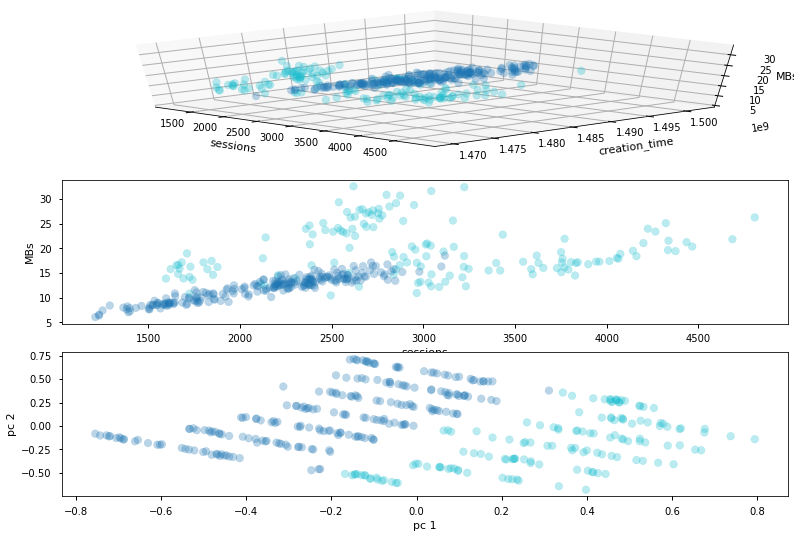

In [15]:
#@title Generate `k` clusters { run: "auto", vertical-output: true }
import sklearn
from sklearn import preprocessing
import pandas as pd
from sklearn import cluster
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
plt.style.use('seaborn-notebook')

k = 2 #@param {type:"slider", min:1, max:5, step:1}
feature = "creation_time" #@param ["creation_time", "dow"]

columns = df.columns
matrix = df.values

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(matrix)
df_scaled = pd.DataFrame(x_scaled)
df_scaled.columns = columns

km = sklearn.cluster.KMeans(n_clusters=k)
km.fit(df_scaled)
labels = km.labels_
clusters = pd.DataFrame({'labels': labels})
output = df.join(clusters)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc 1', 'pc 2'])
pcadf = pd.concat([principalDf, output[['labels']]], axis = 1)

#plotting
fig = plt.figure(figsize=(13, 9))
ax1 = fig.add_subplot(311, projection='3d')
ax1.scatter(output.row_count,  output[feature], output.MBs, c=output.labels, cmap='tab10', marker='o', s=60, alpha=.3)
ax1.set_xlabel('sessions', labelpad=25)
ax1.set_ylabel(feature, labelpad=25)
ax1.set_zlabel('MBs')
ax1.view_init(40,-45)

ax2 = fig.add_subplot(312)
ax2.scatter(output.row_count,  output.MBs, c=labels, cmap='tab10', marker='o', s=60, alpha=.3)
ax2.set_xlabel('sessions')
ax2.set_ylabel('MBs')

ax3 = fig.add_subplot(313)
ax3.scatter(pcadf['pc 1'],  pcadf['pc 2'], c=labels, cmap='tab10', marker='o', s=60, alpha=.3)
ax3.set_xlabel('pc 1')
ax3.set_ylabel('pc 2')

plt.show()

## Review Google Cloud Platform and BigQuery

### Google BigQuery:
![Continuous Improvement](https://storage.googleapis.com/adswerve-bigquery-training/images/continuous_improvement.png)

#### [Building a Marketing Data Warehouse on GCP](https://cloud.google.com/solutions/marketing-data-warehouse-on-gcp)
![Marketing Data Warehouse](https://storage.googleapis.com/adswerve-bigquery-training/images/gcp_marketing_data_warehouse.png)





## Estimating Storage Costs

In [16]:
#@title Estimate BQ Storage Costs { run: "auto", vertical-output: true }
avg_hits_per_session = "15" #@param ["5", "10", "15", "25", "35", "50"]
session_per_month =  500000#@param {type:"integer"}
#hit_growth_rate = 0.05 #@param {type:"slider", min:0.01, max:0.25, step:0.01}
forecast_periods = 36 #@param ["12", "24", "36", "48", "60"] {type:"raw"}
cumulative_periods = ((forecast_periods-1)*forecast_periods)/2+forecast_periods
cost_per_gb = 0.01
sessions_per_gb = int(5e5/int(avg_hits_per_session))
gb_per_period = session_per_month/sessions_per_gb
#ga_period_cost = (cumulative_periods*gb_per_period)*(1+(hit_growth_rate*forecast_periods))*cost_per_gb
ga_period_cost = (cumulative_periods*gb_per_period)*cost_per_gb
print("GA Costs / Month: ${}".format(round(ga_period_cost/forecast_periods,2)))
print("Total Forecast Cost: ${}".format(round(ga_period_cost,2)))

GA Costs / Month: $2.78
Total Forecast Cost: $99.9


## Example Queries

### Getting Started
GA Export Schema: https://support.google.com/analytics/answer/3437719

In [17]:
%%bigquery
SELECT fullVisitorId, visitId, channelGrouping, customDimensions, hits, totals  
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
WHERE totals.pageviews > 1
LIMIT 5

,fullVisitorId,visitId,channelGrouping,customDimensions,hits,totals
0,0446881336866901267,1501604163,Organic Search,"[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 9, 'minut...","{'visits': 1, 'hits': 2, 'pageviews': 2, 'time..."
1,7639981567880780476,1501614025,Organic Search,"[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...","{'visits': 1, 'hits': 2, 'pageviews': 2, 'time..."
2,1323143631015435941,1501612621,Direct,"[{'index': 4, 'value': 'Central America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 11, 'minu...","{'visits': 1, 'hits': 2, 'pageviews': 2, 'time..."
3,5170381678885002061,1501639088,Organic Search,"[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 18, 'minu...","{'visits': 1, 'hits': 2, 'pageviews': 2, 'time..."
4,827047554351375578,1501647074,Direct,"[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 21, 'minu...","{'visits': 1, 'hits': 2, 'pageviews': 2, 'time..."


### Query specific date range
Wildcard Tables: https://cloud.google.com/bigquery/docs/querying-wildcard-tables

In [18]:
%%bigquery
SELECT
  date,
  COUNT(DISTINCT fullVisitorId) AS users,
  SUM(totals.pageviews) AS pageviews,
  SUM(totals.newVisits) AS newVisits,
  AVG(totals.timeOnSite)/60 AS avgTimeOnSite
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20170701' AND '20170707'
  AND totals.visits = 1 -- session has interaction event
GROUP BY date
ORDER BY date ASC

,date,users,pageviews,newVisits,avgTimeOnSite
0,20170701,1946,6562,1773,4.137636
1,20170702,1791,5637,1584,3.940868
2,20170703,1904,6492,1660,4.496179
3,20170704,1799,5740,1564,4.160812
4,20170705,2683,9927,2296,4.112557
5,20170706,2478,8924,2125,3.902714
6,20170707,2213,9266,1859,4.810412


### Unnesting Hits


In [19]:
%%bigquery 
SELECT
  fullVisitorId,
  visitNumber,
  hits.hitNumber AS hitNumber,
  hits.page.pagePath AS pagePath
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`, 
  UNNEST(hits) as hits
WHERE hits.type="PAGE" 
AND fullVisitorId = '5835011534221003810' AND visitNumber = 3
LIMIT 11

,fullVisitorId,visitNumber,hitNumber,pagePath
0,5835011534221003810,3,1,/basket.html
1,5835011534221003810,3,2,/store.html
2,5835011534221003810,3,3,/google+redesign/apparel
3,5835011534221003810,3,4,/google+redesign/apparel/headgear
4,5835011534221003810,3,6,/google+redesign/apparel/headgear/quickview
5,5835011534221003810,3,8,/basket.html
6,5835011534221003810,3,9,/signin.html
7,5835011534221003810,3,10,/yourinfo.html
8,5835011534221003810,3,11,/payment.html
9,5835011534221003810,3,12,/payment.html


### Access Custom Dimensions by Index

In [20]:
%%bigquery
SELECT 
 (SELECT value FROM UNNEST(t.customDimensions) WHERE index=4 LIMIT 1) AS region_cd4,
 COUNT(*) as hit_count
FROM  `bigquery-public-data.google_analytics_sample.ga_sessions_20170801` as t 
GROUP BY 1
ORDER BY hit_count DESC

,region_cd4,hit_count
0,North America,1372
1,EMEA,485
2,None,346
3,APAC,292
4,South America,34
5,Central America,27
